# LSTM-Based stock price prediction

In this notebook, the goal is to **implement and evaluate stock prices prediction** by using **historical data (2 years)**, in order to predict the price of stocks for the next **7 days** by using a **LSTM model**. </br>
The data used were acquired from "yfinance" library, and the LSTM model from "keras" library.

# Importing the libraries

In [2]:
import math
import datetime
import time
import seaborn as sns 
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import MinMaxScaler 
import tensorflow as tf
from pandas_datareader.data import DataReader
from keras.callbacks import EarlyStopping
import plotly.graph_objs as go
import plotly.io as pio
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
pio.templates
from datetime import date 
from pandas.core.common import SettingWithCopyWarning
from tensorflow import keras
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from keras import layers
from datetime import date 
from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
plt.style.use('seaborn-darkgrid')


# Libraries' versions and Hardware specifications 

In [3]:
%reload_ext watermark
%watermark
%watermark --iversions

Last updated: 2022-08-26T20:46:00.167531+03:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.0.1

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 23 Model 96 Stepping 1, AuthenticAMD
CPU cores   : 16
Architecture: 64bit

yfinance  : 0.1.74
matplotlib: 3.4.3
keras     : 2.9.0
tensorflow: 2.9.1
sys       : 3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]
pandas    : 1.3.4
seaborn   : 0.11.2
plotly    : 5.10.0
numpy     : 1.22.3



# Getting the data

The code block below downloads the data from **Yahoo Finance** from **2020-08-25** to **2022-08-25** for each one of the tech stocks we chose below. </br>
This 2-years time period will be used to evaluate our model and perform the Explanatory Data Analysis.

In [21]:
companies = ['AAPL', 'NVDA', 'PYPL', 'MSFT','AMZN','SPOT','TWTR','ABNB','UBER','GOOG'] # They are the companies that we will examine

end="2022-08-26"  # The yahoo finance will return the data for 2022-08-25
start="2020-08-26" # The yahoo finance will return the data for 2020-08-25

for stock in companies:
    globals()[stock] = yf.download(stock,start=start,end=end)
    
end="2022-08-25"
start="2020-08-25"
company_list = [AAPL,NVDA,PYPL,MSFT,AMZN,SPOT,TWTR,ABNB,UBER,GOOG]
company_name = ["APPLE", "NVIDIA", "PAYPAL", "MICROSOFT","AMAZON","SPOTIFY","TWITTER","AIRBNB","UBER","GOOGLE"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df=df.reset_index()

df['Date'] = pd.to_datetime(df['Date'])
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
df['month_year'] = df['Date'].dt.to_period('M')
df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,company_name,year,month,day,month_year
0,2020-08-25,124.697502,125.180000,123.052498,124.824997,123.336159,211495600,APPLE,2020,8,25,2020-08
1,2020-08-26,126.180000,126.992500,125.082497,126.522499,125.013412,163022400,APPLE,2020,8,26,2020-08
2,2020-08-27,127.142502,127.485001,123.832497,125.010002,123.518944,155552400,APPLE,2020,8,27,2020-08
3,2020-08-28,126.012497,126.442497,124.577499,124.807503,123.318878,187630000,APPLE,2020,8,28,2020-08
4,2020-08-31,127.580002,131.000000,126.000000,129.039993,127.500893,225702700,APPLE,2020,8,31,2020-08
...,...,...,...,...,...,...,...,...,...,...,...,...
4970,2022-08-19,119.870003,120.000000,117.669998,118.120003,118.120003,20171100,GOOGLE,2022,8,19,2022-08
4971,2022-08-22,116.099998,116.500000,114.669998,115.070000,115.070000,19316000,GOOGLE,2022,8,22,2022-08
4972,2022-08-23,114.320000,115.930000,114.300003,114.769997,114.769997,14390700,GOOGLE,2022,8,23,2022-08
4973,2022-08-24,114.449997,115.717003,113.779999,114.699997,114.699997,16051200,GOOGLE,2022,8,24,2022-08


It must be noted that **yfinance** returns us the following fields: </br>
1. **Date**: The date in which the record corresponds to
2. **Open**: The stock's opening price of the day
3. **High**: The stock's highest price of the day
4. **Low**: The stock's lowest price of the day
5. **Close**: The stock's closing price of the day
6. **Adj Close**: The stock's closing price of the day, **adjusted to stock's splits, dividends, and other corporate actions** </br>

</br>
In our analysis, we will use the "Adj Close" price only.

# Plotting Stock Price Historical Data

Below, we can see the time-series line-plot for each one of the stocks chosen. 

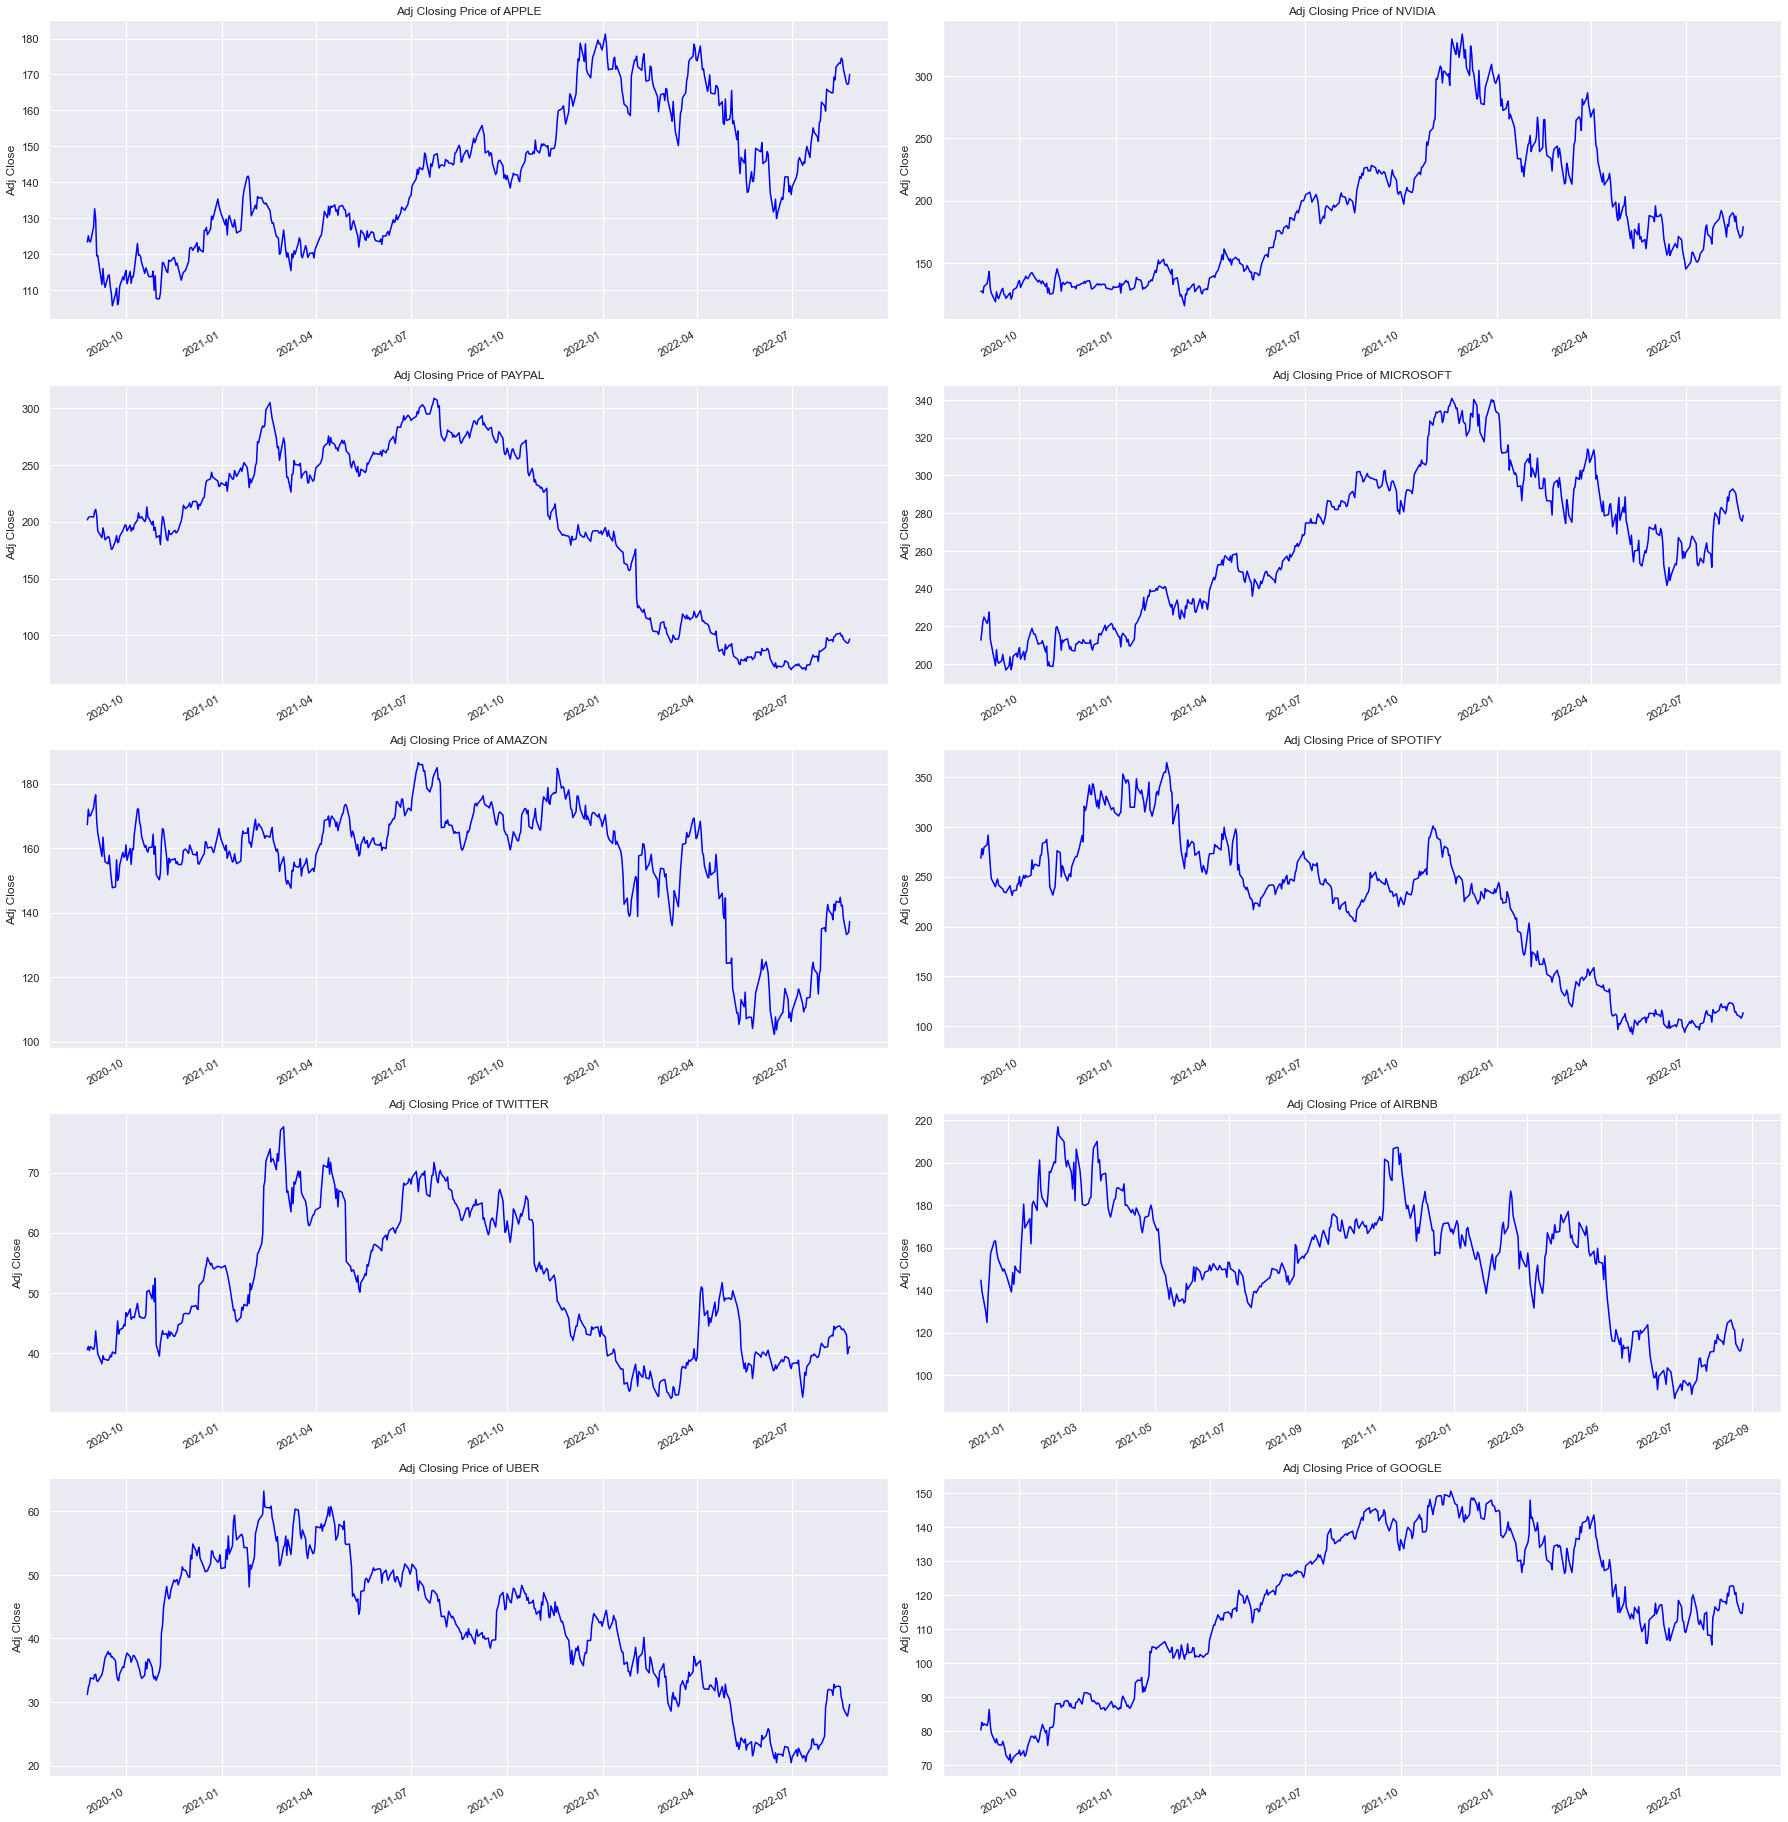

In [22]:
plt.figure(figsize=(25, 30))
for i, company in enumerate(company_list, 1):
    plt.subplot(6,2, i)
    company['Adj Close'].plot(color='blue')
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Adj Closing Price of {company_name[i-1]}")
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

plt.tight_layout()

It must be noted that stock market prices are highly unpredictable, volatile and theiy are affected from a great number of factors. This means that there are no consistent patterns in the data that allow us to model stock prices over time near-perfectly, and this is visible in the plots above. However, we expect that LSTM will be able to capture the basic trend of the stock price even approximately. </br>
</br>
Additionally, these plots "share" a mostly common trend, since they belong to the same industry (Tech), but if we would compare them with a stock belonging to the "Pharmaceutical" industry for example, the trends would not be that similar. 

# Correlation between stocks' prices

In the final web app, we decided to only include large-capitalisation stocks from the NASDAQ and NYSE that belong to the same sector (tech), because we expect that they follow mostly similar trends since they belong to the same economy and industry. </br>
To reassure the above, we will examine the correlation between their prices.

<AxesSubplot:>

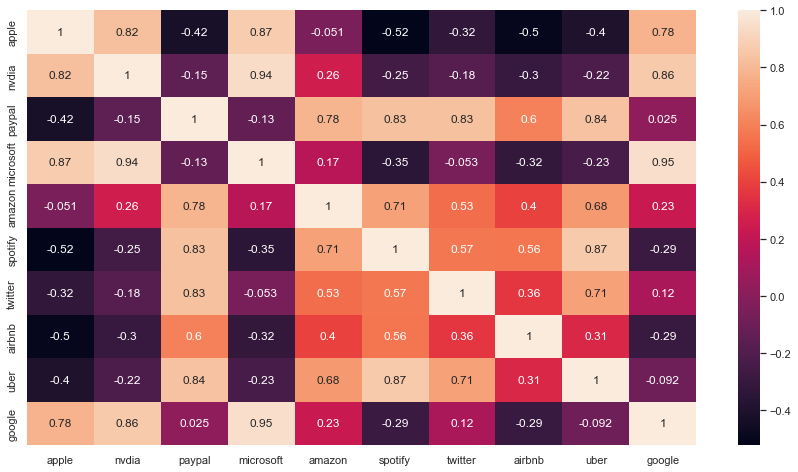

In [23]:
### create a blank dataframe
close=pd.DataFrame()
close1=pd.DataFrame().reset_index(drop=True)
close2=pd.DataFrame().reset_index(drop=True)
close3=pd.DataFrame().reset_index(drop=True)
close4=pd.DataFrame().reset_index(drop=True)
close6=pd.DataFrame().reset_index(drop=True)
close7=pd.DataFrame().reset_index(drop=True)
close8=pd.DataFrame().reset_index(drop=True)
close9=pd.DataFrame().reset_index(drop=True)
close10=pd.DataFrame().reset_index(drop=True)
close11=pd.DataFrame().reset_index(drop=True)


close1['apple']=df['Adj Close'][df['company_name'] == "APPLE"]
close1=close1.reset_index(drop=True)
close2['nvdia']=df['Adj Close'][df['company_name'] == "NVIDIA"]
close2=close2.reset_index(drop=True)
close3['paypal']=df['Adj Close'][df['company_name'] == "PAYPAL"]
close3=close3.reset_index(drop=True)
close4['microsoft']=df['Adj Close'][df['company_name'] == "MICROSOFT"]
close4=close4.reset_index(drop=True)
close6['amazon']=df['Adj Close'][df['company_name'] == "AMAZON"]
close6=close6.reset_index(drop=True)
close7['spotify']=df['Adj Close'][df['company_name'] == "SPOTIFY"]
close7=close7.reset_index(drop=True)
close8['twitter']=df['Adj Close'][df['company_name'] == "TWITTER"]
close8=close8.reset_index(drop=True)
close9['airbnb']=df['Adj Close'][df['company_name'] == "AIRBNB"]
close9=close9.reset_index(drop=True)
close10['uber']=df['Adj Close'][df['company_name'] == "UBER"]
close10=close10.reset_index(drop=True)
close11['google']=df['Adj Close'][df['company_name'] == "GOOGLE"]
close11=close11.reset_index(drop=True)

close = pd.concat([close1,close2,close3,close4,close6,close7,close8,close9,close10,close11], axis=1)

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(close.corr(),annot=True,cmap='rocket')

As expected, most stocks show a positive linear correlation in their prices, with **Microsoft** and **Google** showing the strongest correlation. This means that only including and studying stocks of a specific sector only makes some sense.

# LSTM Model Creation and Evaluation 

We will now create and evaluate our model. The prediction of the stock prices is fundamentally a **Regression Problem** so in order to evaluate our models we will use the `R-squared` and the `Root Mean Square Error` metrics.
Our model will be fed with data from `2020-08-25` until `2022-08-25` ( 2 years period ) in order to provide predictions for the next 7 days.

In [10]:
def LSTM_Evaluation(Ticker):
    # the following dates are chosen manually for the EDA only
    end="2022-08-26"  # The yahoo finance will return the data for 2022-08-25
    start="2020-08-26" # The yahoo finance will return the data for 2020-08-25
    stock_data = yf.download(tickers=str(Ticker),start=start,end=end) 
    stock_data=pd.DataFrame(data=stock_data).drop(['Open','High','Low','Close', 'Volume'],axis=1).reset_index()
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data=stock_data.dropna()

    # Taking the 80% of the data as train set
    close_prices = stock_data['Adj Close']
    values = close_prices.values
    training_data_len = math.ceil(len(values)* 0.8)
    # Normalizing our data so that all the values would be ranged from 0 to 1.
    # With Scikit-Learn MinMaxScaler we were able to normalize our data ranging from 0 to 1 and 
    # after that we reshaped it into a 2-Dimensional array.

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(values.reshape(-1,1))
    train_data = scaled_data[0: training_data_len, :]

    x_train = []
    y_train = []
    # After that we created a 60-days window of historical prices (i-60) as our feature data (x_train) 
    # and the following 60-days window as label data (y_train).
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    # In order to feed our model with the transformed data we had to
    #  reshape the x_train and y_train into a 3-Dimensional array.
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    test_data = scaled_data[training_data_len-60: , : ]
    x_test = []
    y_test = values[training_data_len:]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # This function takes us input the hyparemeters that every model needs.

    def LSTM_trainer(seed, DROPOUT, LSTM_units,patience,batch_size, epochs):
        global history
        tf.random.set_seed(seed)
        DROPOUT = DROPOUT
        global model_lstm
        model_lstm = keras.Sequential()
        model_lstm.add(layers.LSTM(LSTM_units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        model_lstm.add(Dropout(rate=DROPOUT))
        model_lstm.add(layers.LSTM(LSTM_units, return_sequences=False))
        model_lstm.add(Dropout(rate=DROPOUT))
        model_lstm.add(layers.Dense(25))
        model_lstm.add(Dropout(rate=DROPOUT))
        model_lstm.add(layers.Dense(1))
        model_lstm.add(Activation('linear'))
        
        print('\n')
        print("Compiling the LSTM Model for the "  + str(Ticker) + " stock....\n")
        t0 = time.time()
        model_lstm.compile(optimizer='adam', loss='mean_squared_error',metrics=['mae'])
        callback=EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=patience, 
                              verbose=1, mode='auto')            
        history=model_lstm.fit(x_train, 
                          y_train,
                          batch_size= batch_size, 
                          epochs=epochs,
                          validation_split=0.1, # ...holding out 10% of the data for validation 
                          shuffle=True,verbose=0,callbacks=[callback])
        t1 = time.time()
        global ex_time
        ex_time = round(t1-t0, 2)
        print("Compiling took :",ex_time,"seconds")

    # In this part of the code we assign the proper hyperparameters 
    # for each stock to the lstm trainer function.    

    if Ticker == 'AAPL':
        LSTM_trainer(1, 0.2, 100,2, 20, 30)
    elif Ticker == 'NVDA':
        LSTM_trainer(2, 0.2, 100,2, 30, 50)    
    elif Ticker == 'PYPL':
        LSTM_trainer(6, 0.2, 100,10,25, 30)
    elif Ticker == 'MSFT':
        LSTM_trainer(4, 0.1, 80, 2,20, 40)
    elif Ticker == 'TSLA':
        LSTM_trainer(5, 0.1, 120, 4,20, 25)
    elif Ticker == 'AMZN':
        LSTM_trainer(6, 0.1, 120,2, 20, 25)    
    elif Ticker == 'SPOT':
        LSTM_trainer(9, 0.2, 200,5, 20, 40)
    elif Ticker == 'TWTR' :
        LSTM_trainer(15, 0.2, 100,4,20, 40)
    elif Ticker == 'UBER':
        LSTM_trainer(15, 0.2, 100,7,20, 40)
    elif Ticker == 'ABNB':
        LSTM_trainer(15, 0.2, 120,8,20, 40)
    elif Ticker == 'GOOG':
        LSTM_trainer(15, 0.2, 100,3,20, 25)      

    # Plotting the Loss of the each Model
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss of ' + str(Ticker),fontsize=18)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    #### Predictions 

    predictions = model_lstm.predict(x_test)
    #Transform the predictions from values from 0 to 1 into the actual prices.
    predictions = scaler.inverse_transform(predictions)
    
    #Evaluation of the Predictions 
    rmse = np.sqrt(round(mean_squared_error(y_test, predictions),2))
    print('R2 Score: ', round(r2_score(y_test, predictions),2))
    print('RMSE Score ',round(rmse,3))
    
    #### Visualizing the predictions 
    data = stock_data.filter(['Adj Close'])
    train = data[:training_data_len]
    validation = data[training_data_len:]
    validation['Predictions'] = predictions
    plt.figure(figsize=(30,10))
    plt.title('In Sample Predictions of ' + str(Ticker),fontsize=18)
    plt.xlabel('Date',fontsize=18)
    plt.ylabel('Adj Price USD ($)',fontsize=18)
    plt.plot(train)
    plt.plot(validation[['Adj Close', 'Predictions']])
    plt.xticks(stock_data.index,pd.to_datetime(stock_data.Date.values))
    plt.locator_params(axis="x", nbins=9)
    plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right', prop={'size': 16})

[*********************100%***********************]  1 of 1 completed


Compiling the LSTM Model for the AAPL stock....

Epoch 19: early stopping
Compiling took : 17.57 seconds
4/4 [==============================] - 1s 14ms/step
R2 Score:  0.81
RMSE Score  5.483


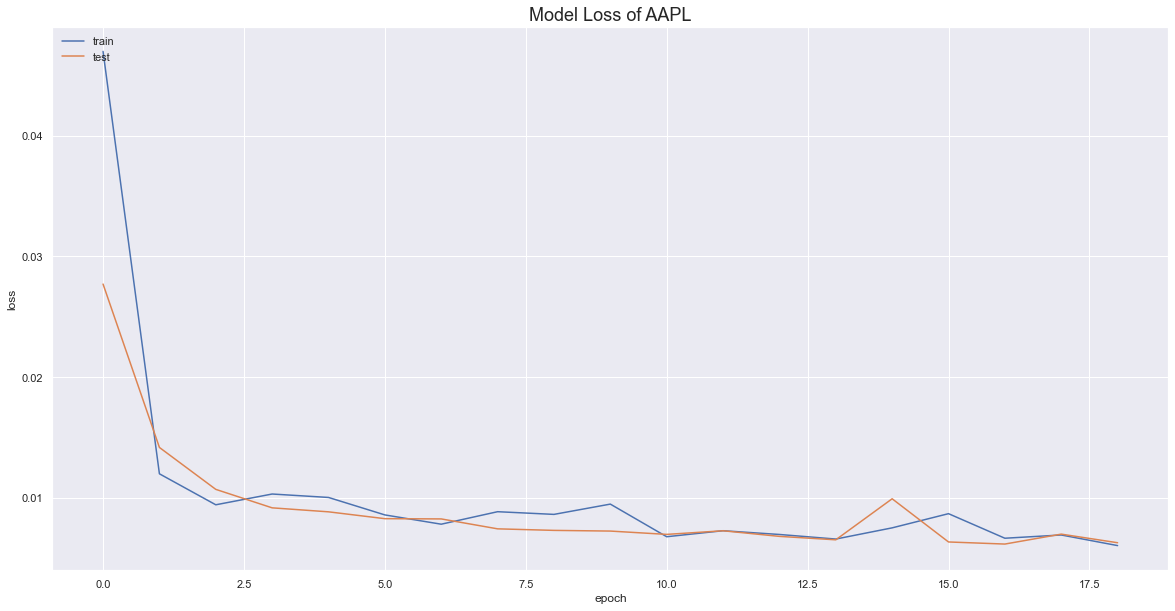

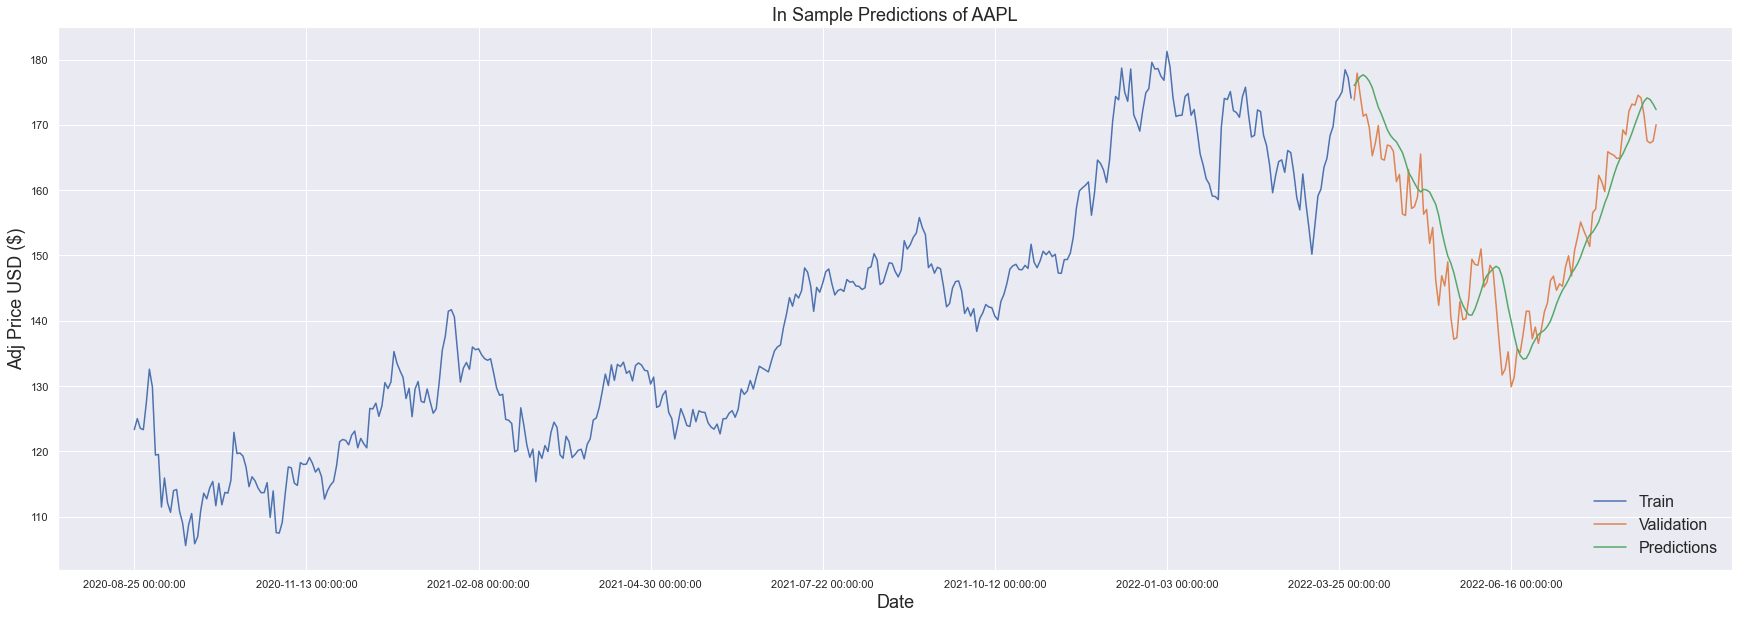

In [11]:
LSTM_Evaluation('AAPL')

[*********************100%***********************]  1 of 1 completed


Compiling the LSTM Model for the NVDA stock....

Epoch 7: early stopping
Compiling took : 8.39 seconds
4/4 [==============================] - 1s 14ms/step
R2 Score:  0.73
RMSE Score  12.945


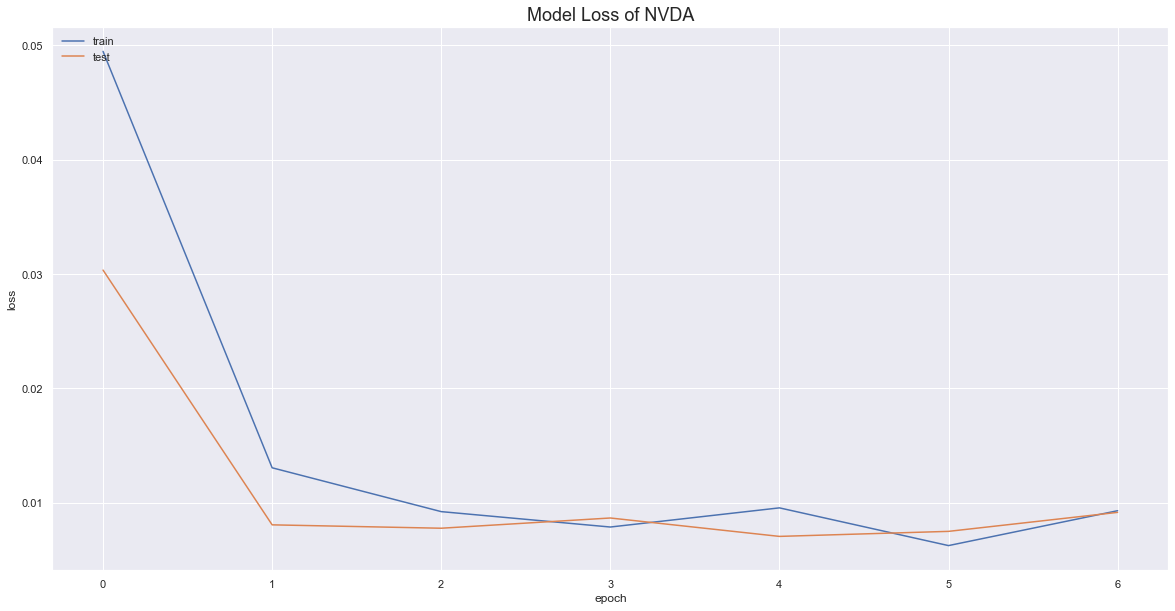

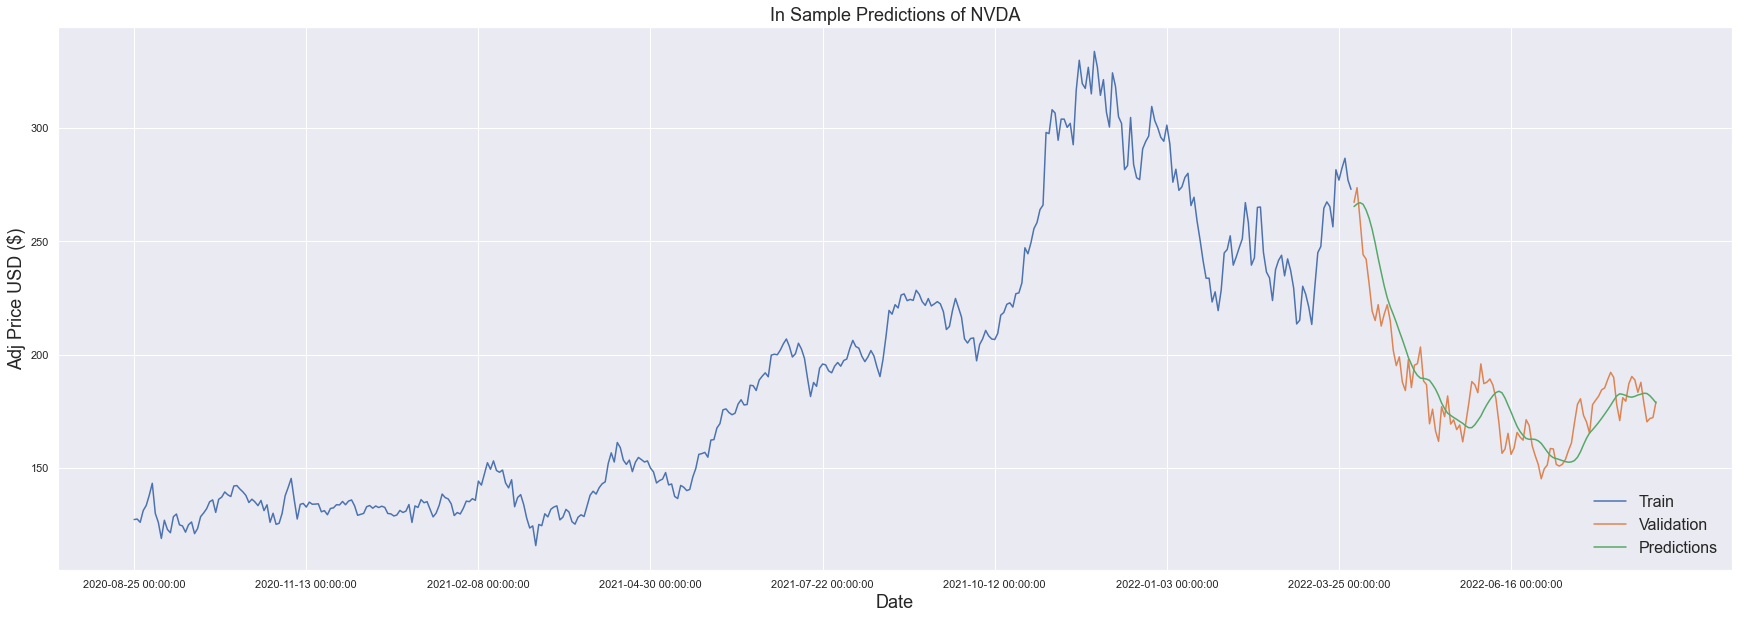

In [12]:
LSTM_Evaluation('NVDA')

[*********************100%***********************]  1 of 1 completed


Compiling the LSTM Model for the PYPL stock....

Compiling took : 22.92 seconds
4/4 [==============================] - 1s 14ms/step
R2 Score:  0.76
RMSE Score  6.056


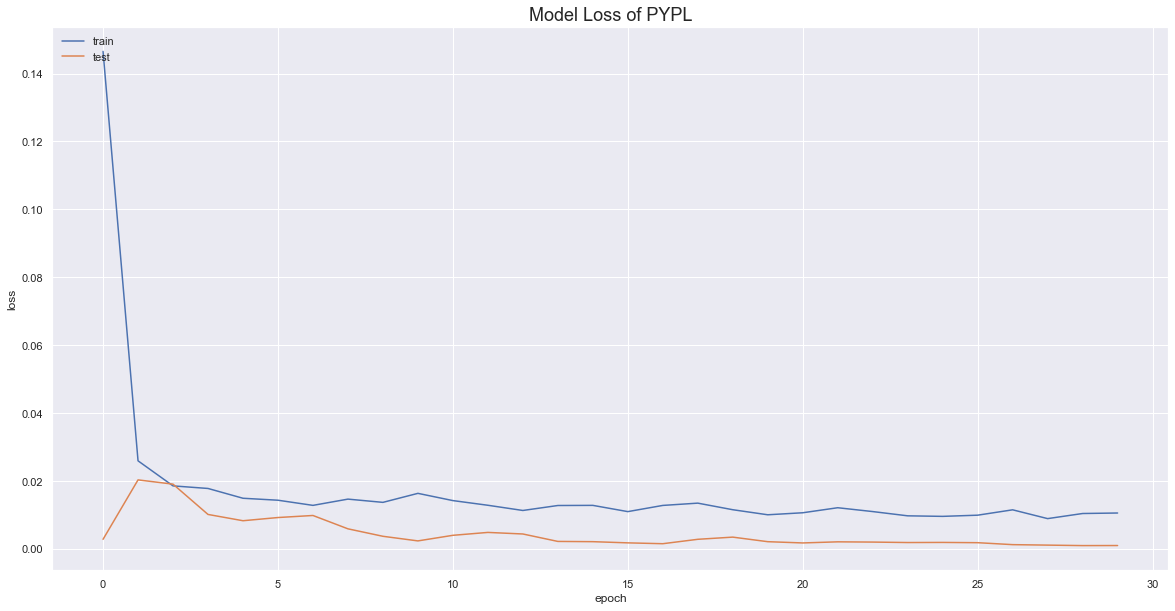

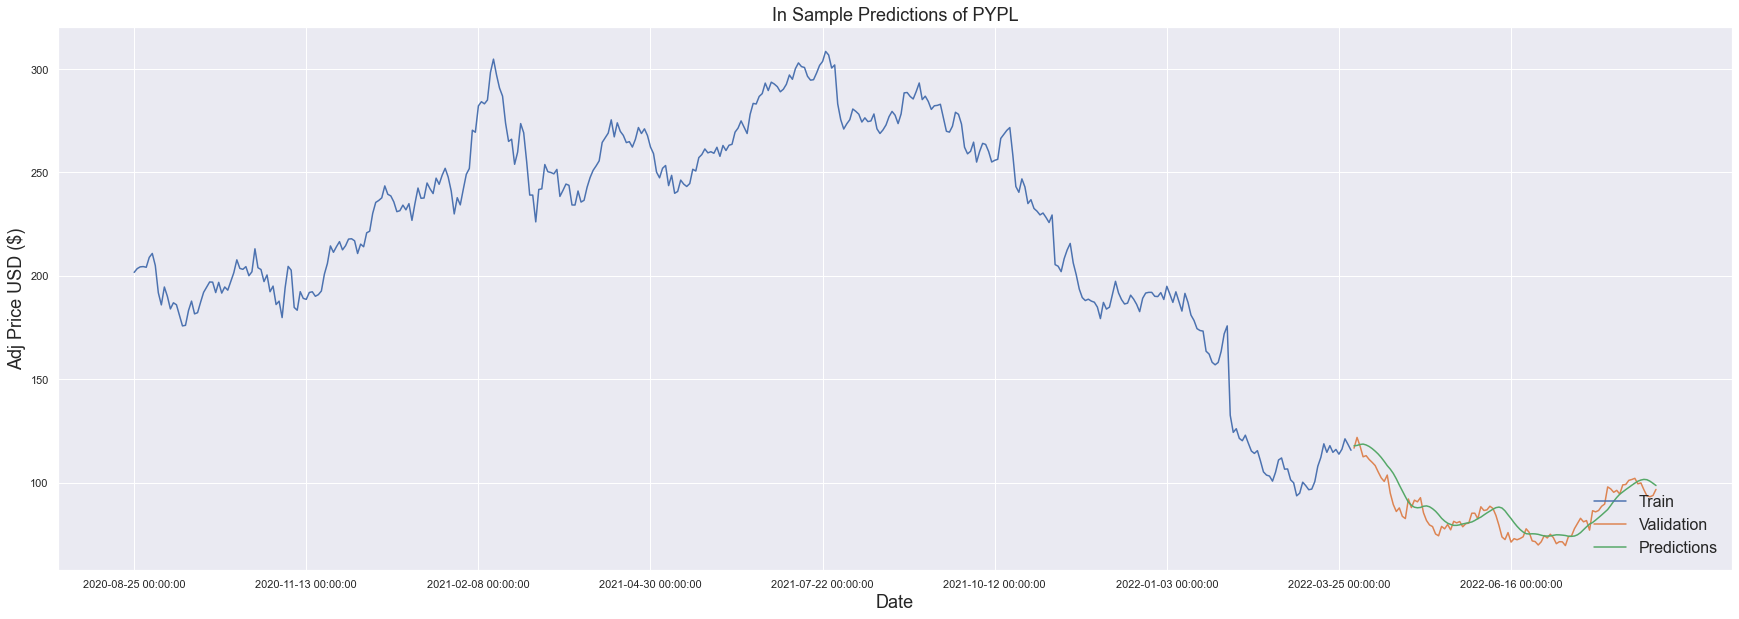

In [13]:
LSTM_Evaluation('PYPL')

[*********************100%***********************]  1 of 1 completed


Compiling the LSTM Model for the MSFT stock....

Epoch 9: early stopping
Compiling took : 8.09 seconds
4/4 [==============================] - 1s 15ms/step
R2 Score:  0.52
RMSE Score  10.469


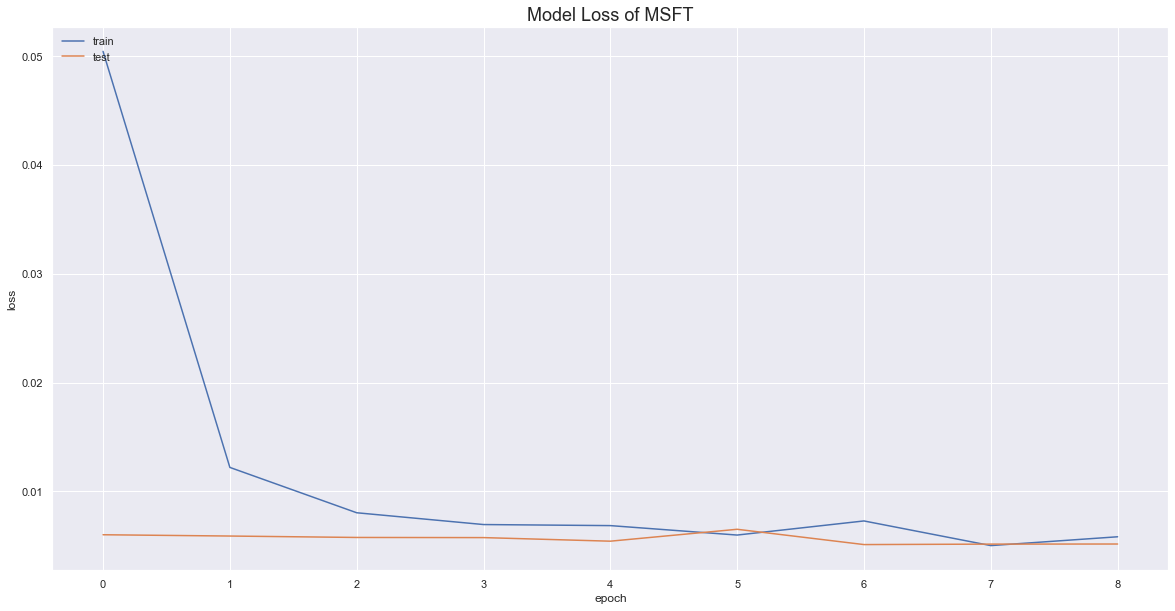

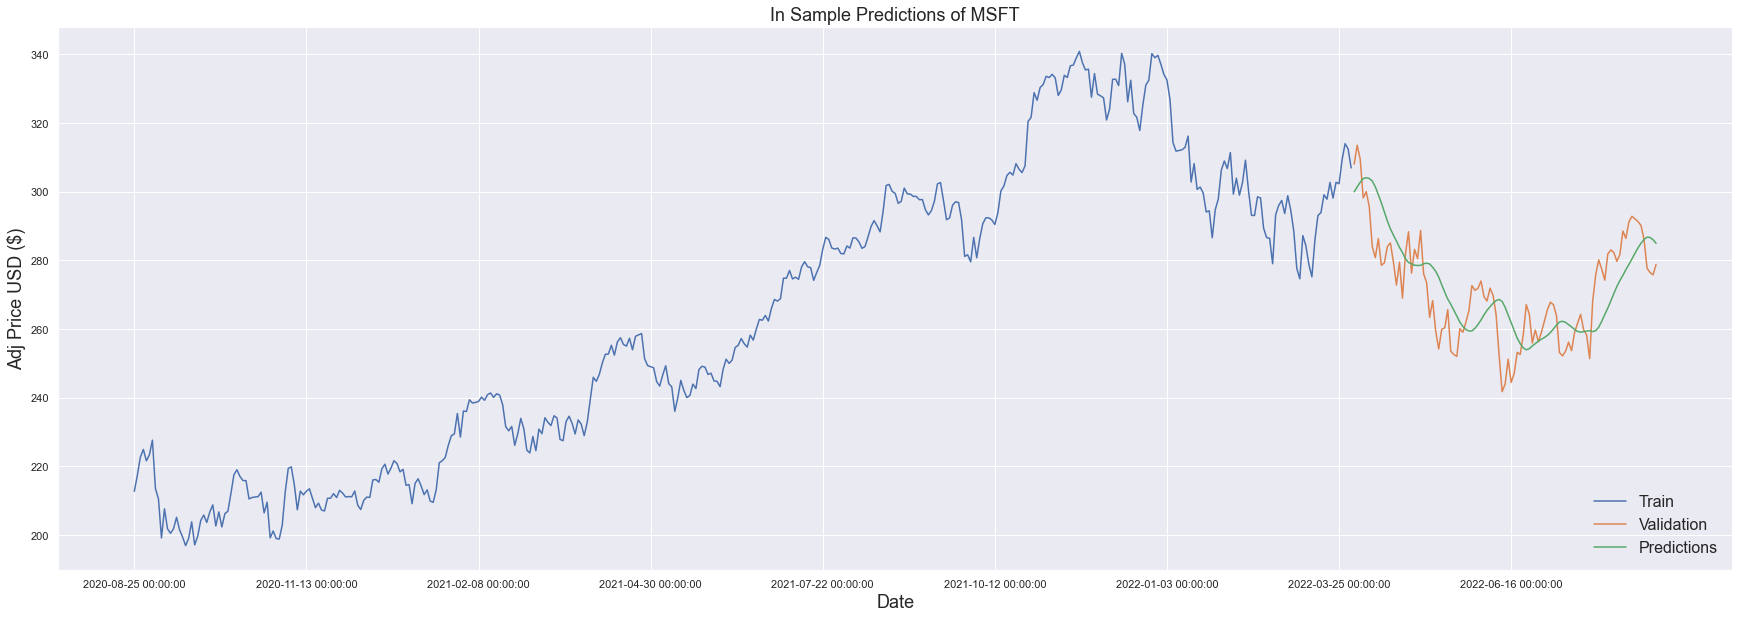

In [14]:
LSTM_Evaluation('MSFT')

[*********************100%***********************]  1 of 1 completed


Compiling the LSTM Model for the AMZN stock....

Epoch 5: early stopping
Compiling took : 9.03 seconds
4/4 [==============================] - 1s 20ms/step
R2 Score:  0.58
RMSE Score  11.236


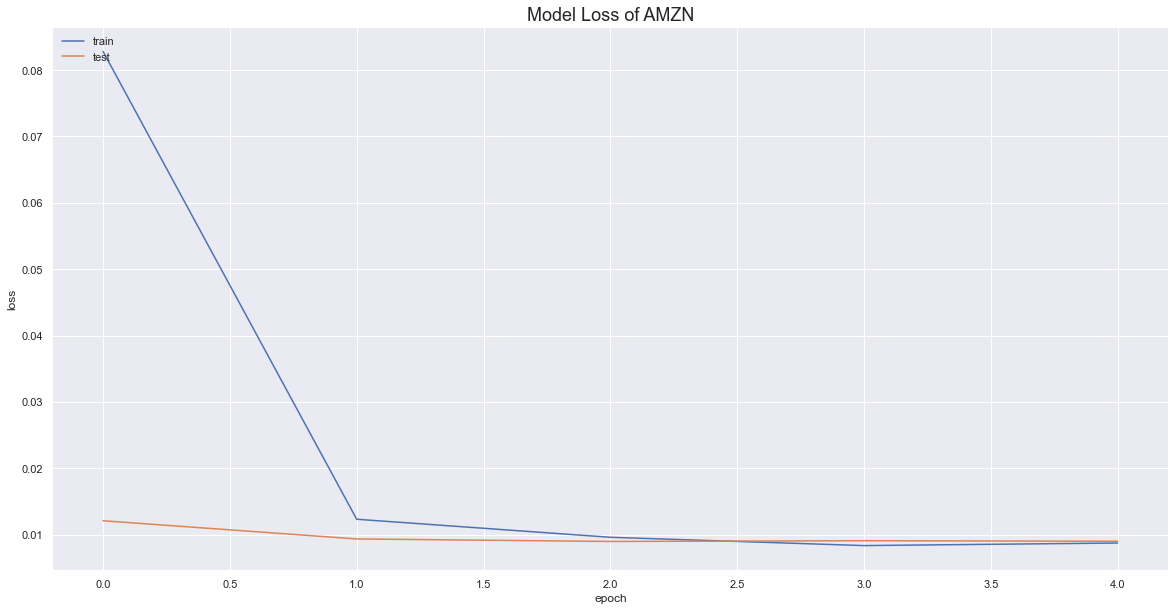

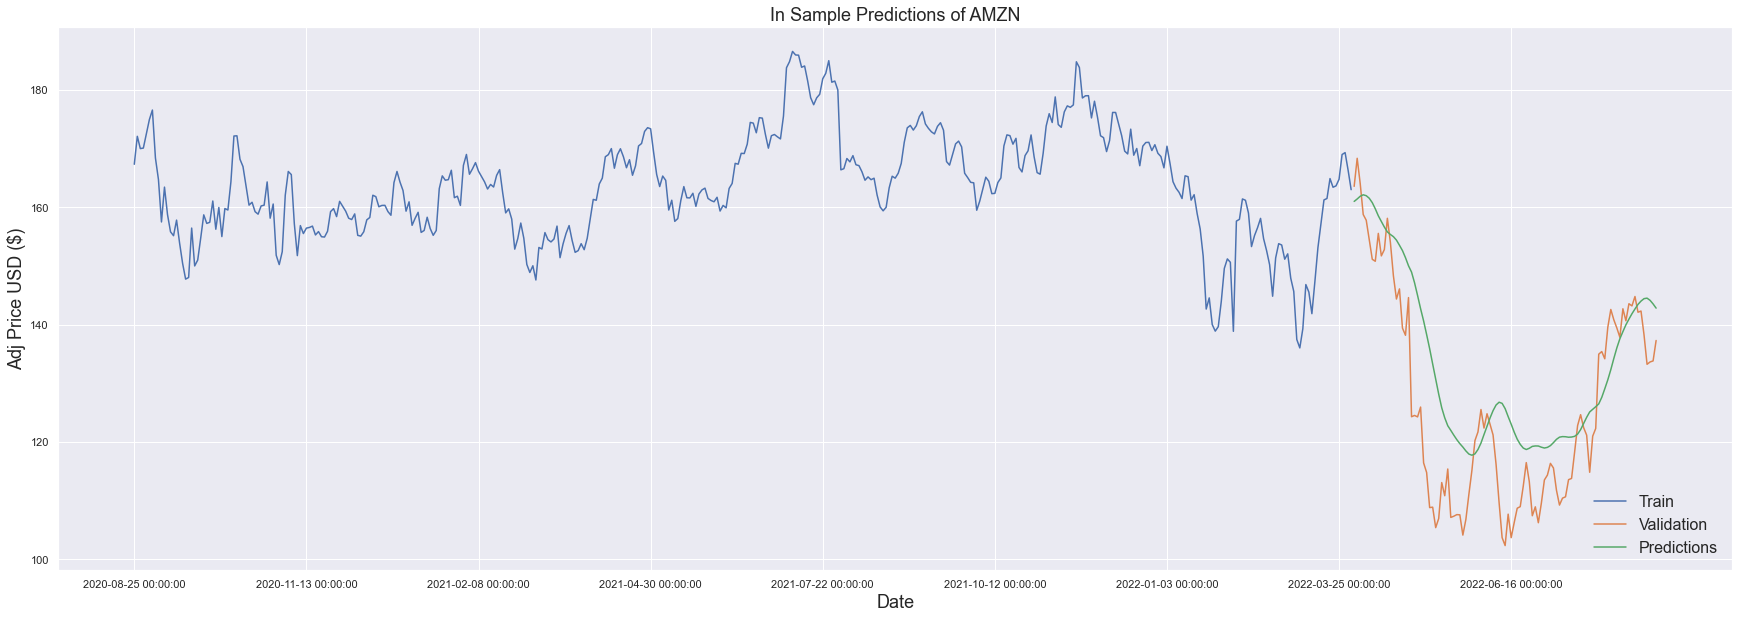

In [15]:
LSTM_Evaluation('AMZN')

[*********************100%***********************]  1 of 1 completed


Compiling the LSTM Model for the SPOT stock....

Epoch 22: early stopping
Compiling took : 60.53 seconds
4/4 [==============================] - 1s 46ms/step
R2 Score:  0.55
RMSE Score  9.124


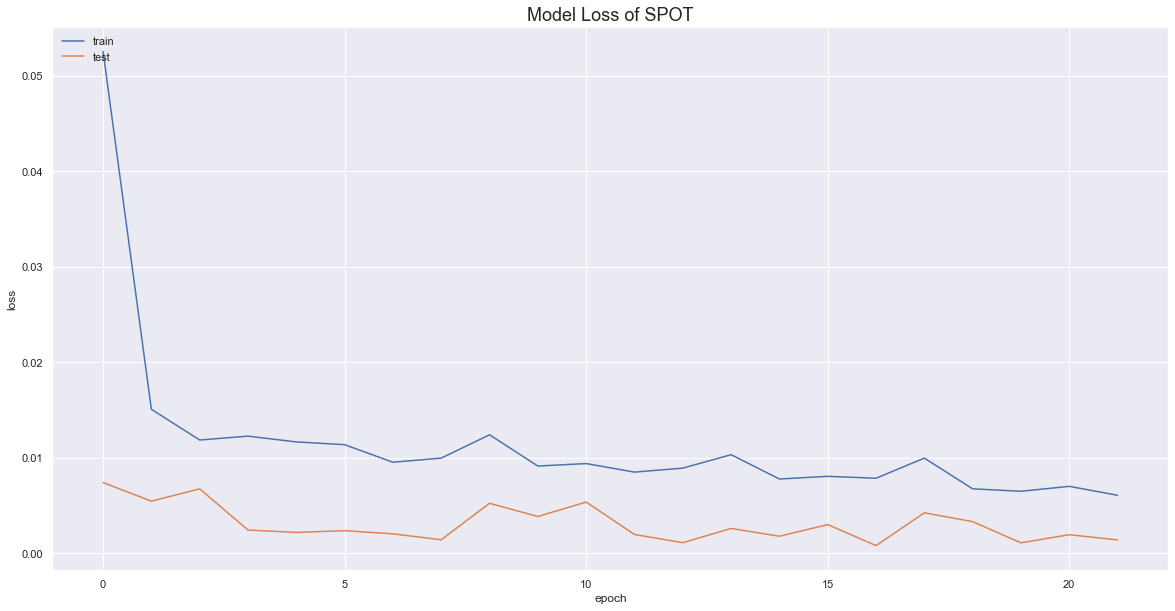

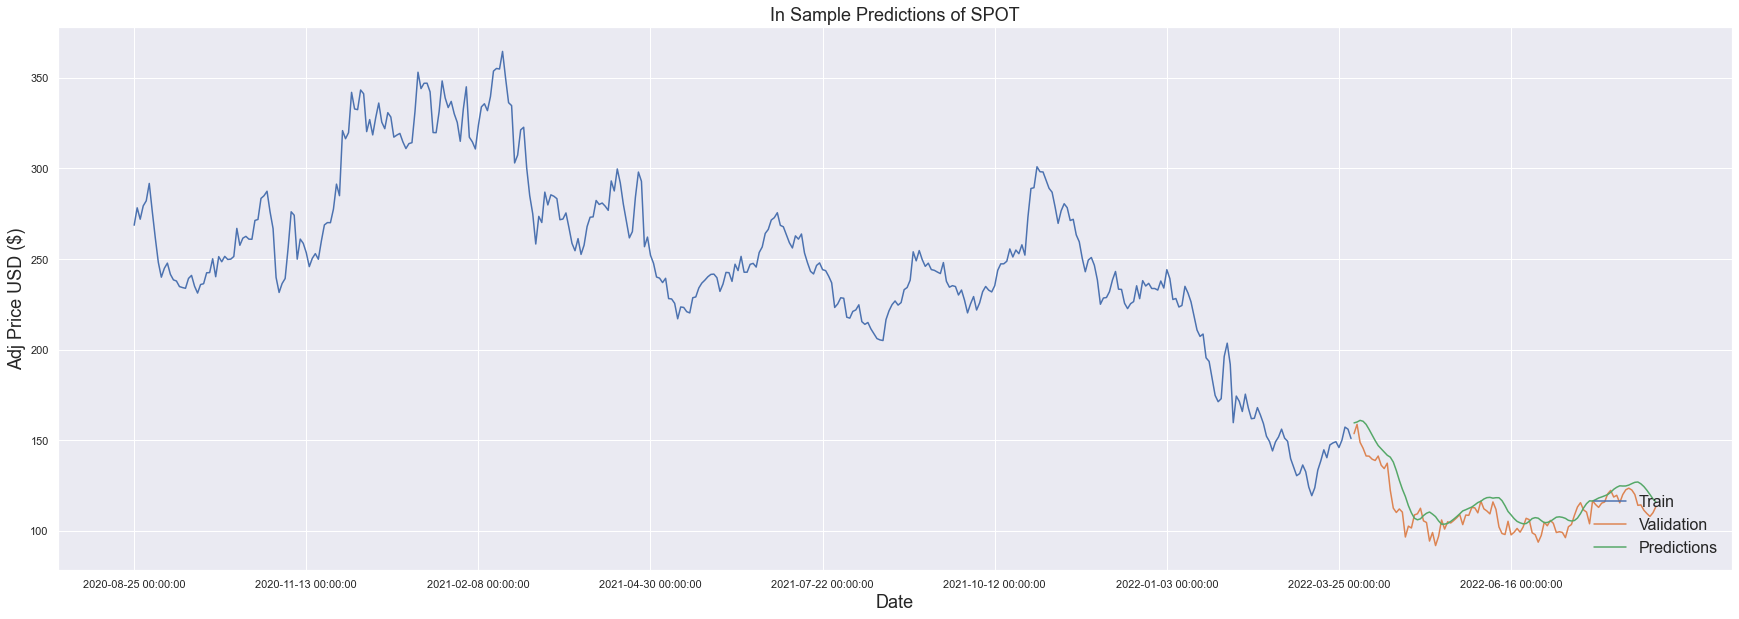

In [16]:
LSTM_Evaluation('SPOT')

[*********************100%***********************]  1 of 1 completed


Compiling the LSTM Model for the TWTR stock....

Epoch 23: early stopping
Compiling took : 29.61 seconds
4/4 [==============================] - 1s 18ms/step
R2 Score:  0.6
RMSE Score  2.811


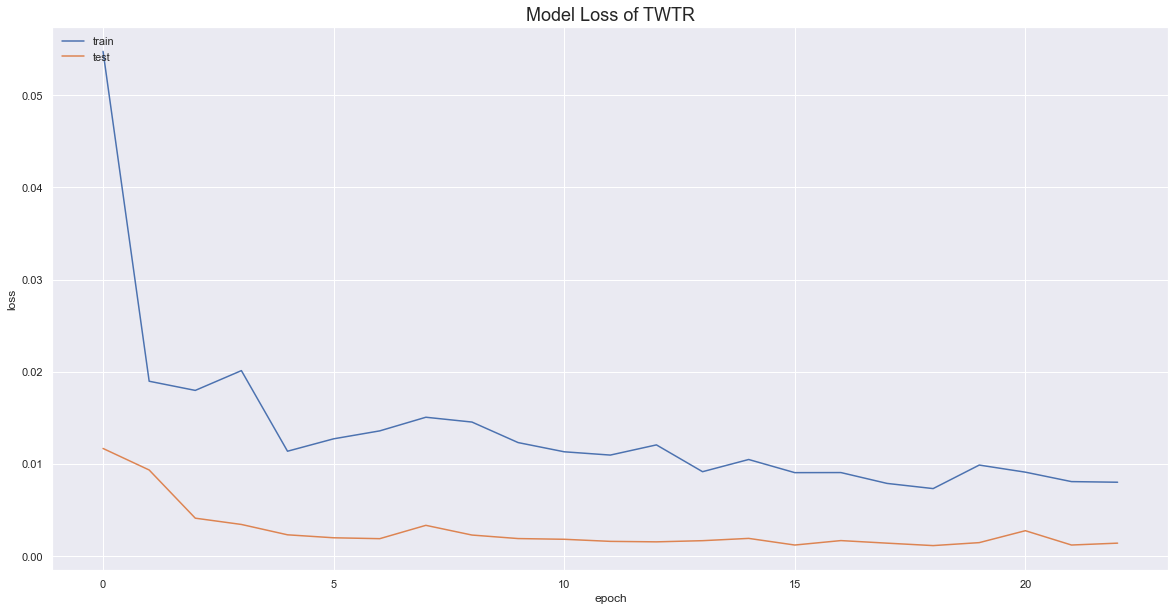

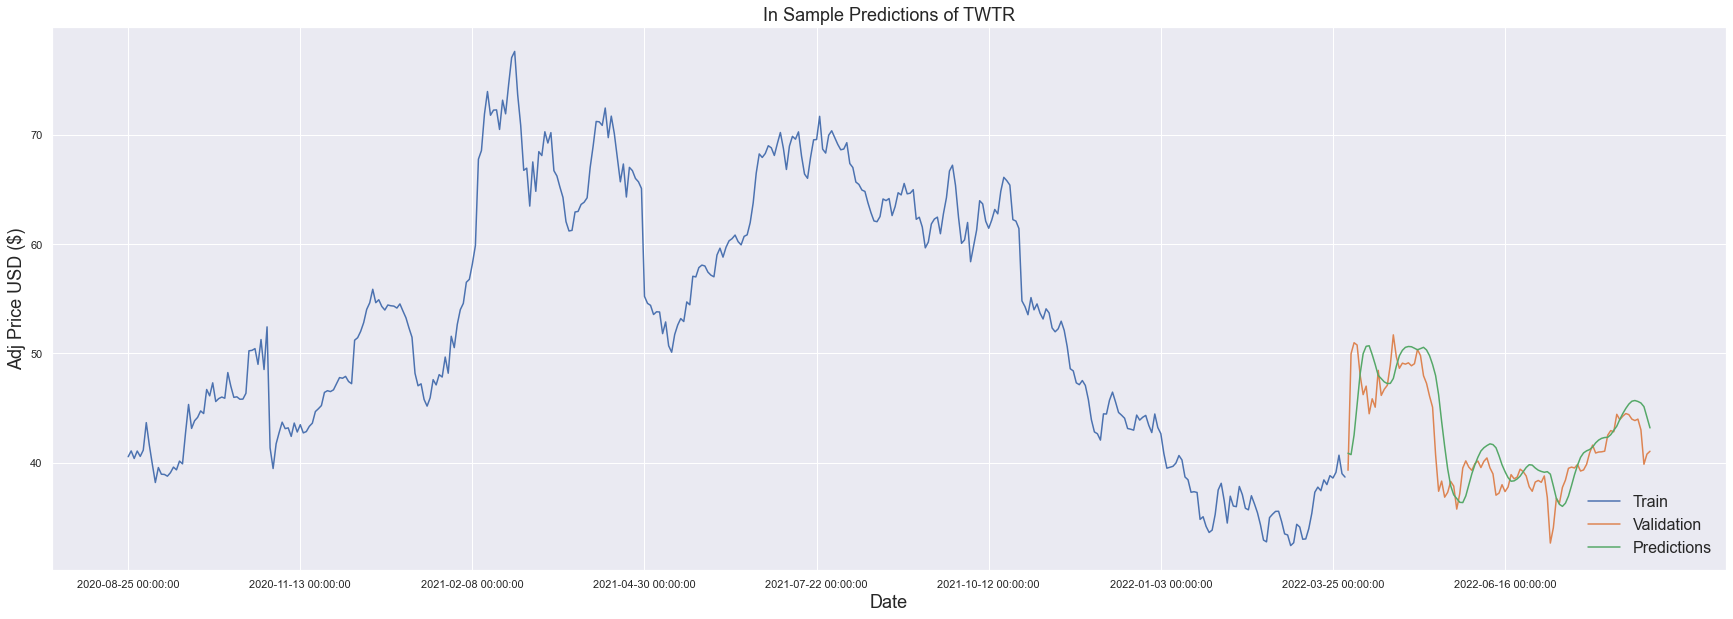

In [17]:
LSTM_Evaluation('TWTR')

[*********************100%***********************]  1 of 1 completed


Compiling the LSTM Model for the UBER stock....

Compiling took : 44.65 seconds
4/4 [==============================] - 1s 22ms/step
R2 Score:  0.79
RMSE Score  2.069


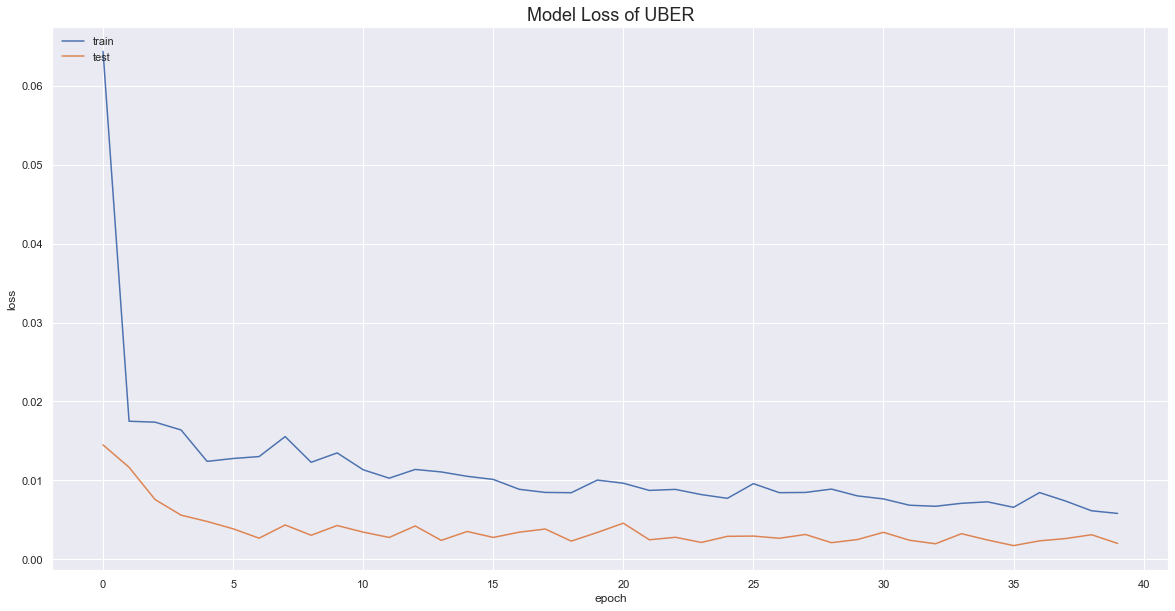

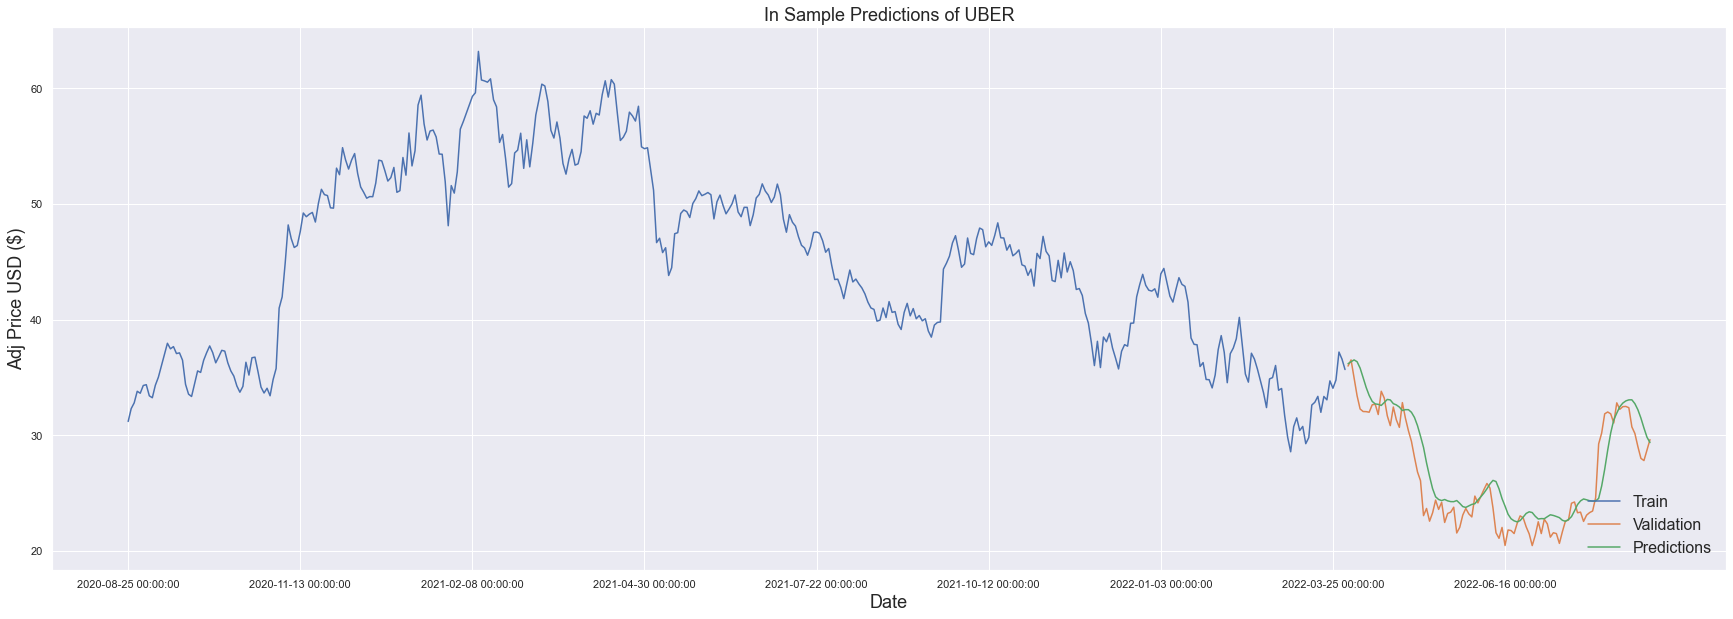

In [18]:
LSTM_Evaluation('UBER')

[*********************100%***********************]  1 of 1 completed


Compiling the LSTM Model for the GOOG stock....

Epoch 16: early stopping
Compiling took : 28.51 seconds
4/4 [==============================] - 1s 24ms/step
R2 Score:  0.68
RMSE Score  4.384


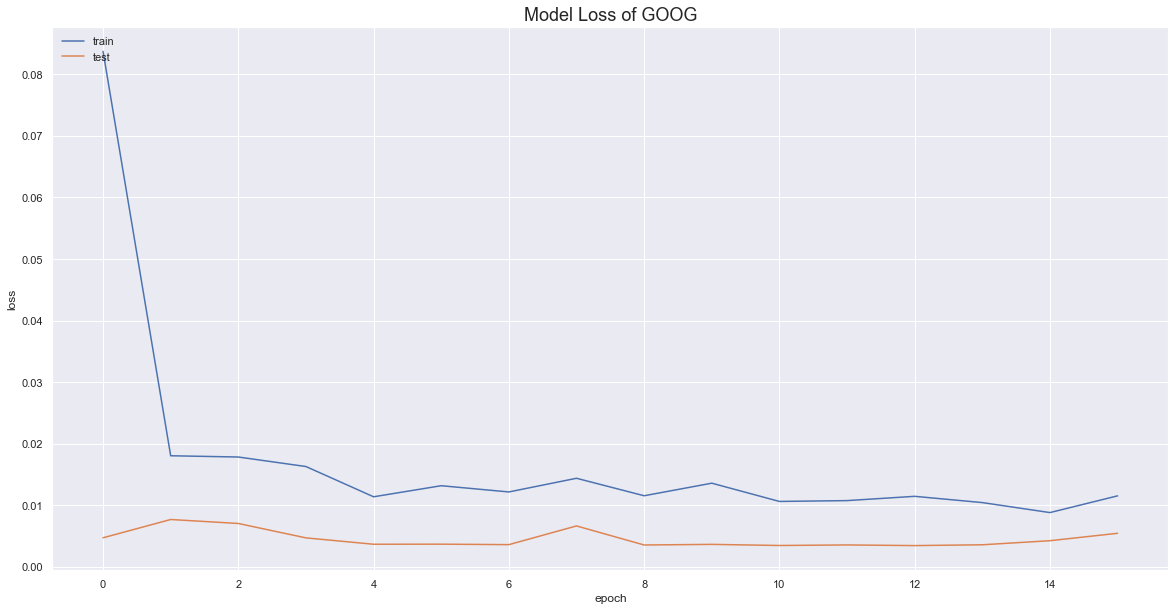

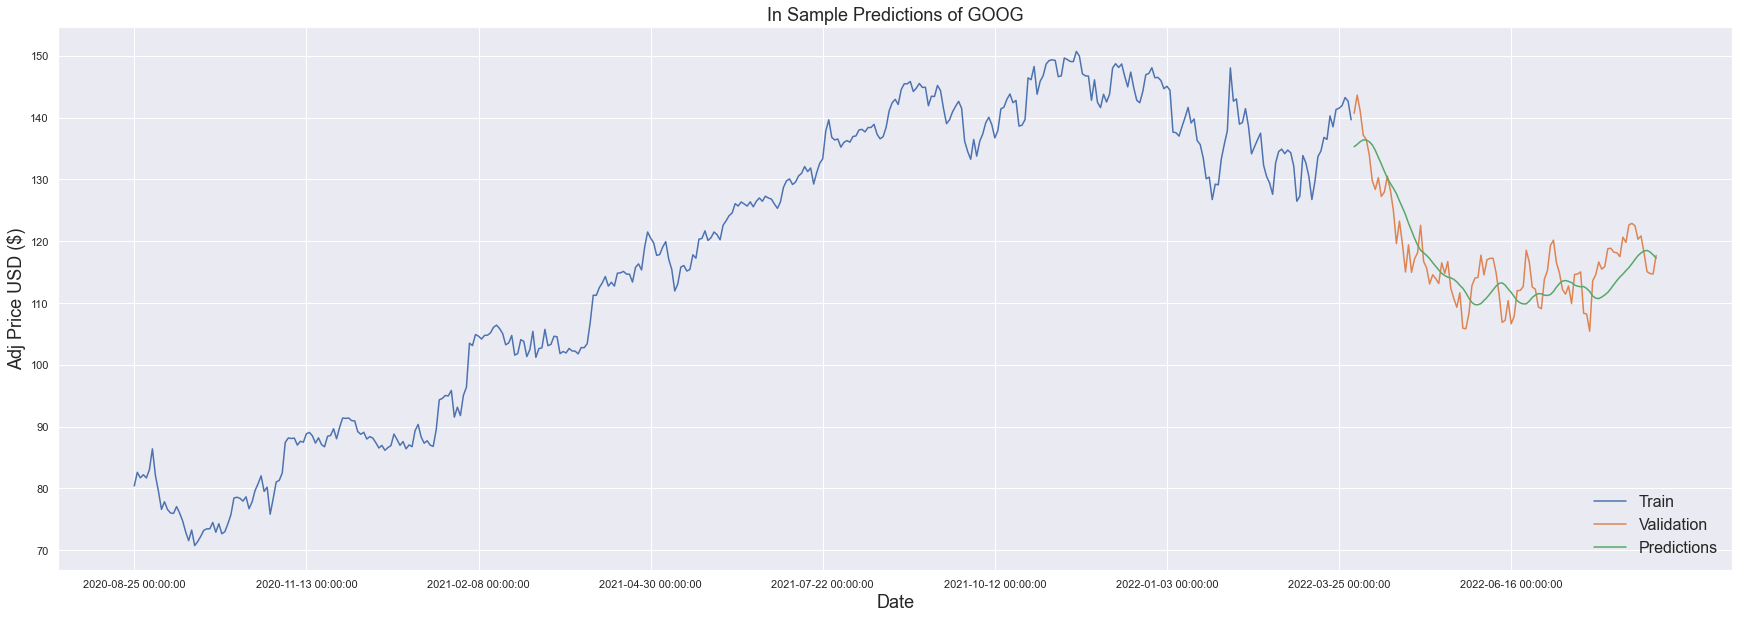

In [19]:
LSTM_Evaluation('GOOG')

[*********************100%***********************]  1 of 1 completed


Compiling the LSTM Model for the ABNB stock....

Epoch 30: early stopping
Compiling took : 50.13 seconds
3/3 [==============================] - 1s 34ms/step
R2 Score:  0.64
RMSE Score  9.956


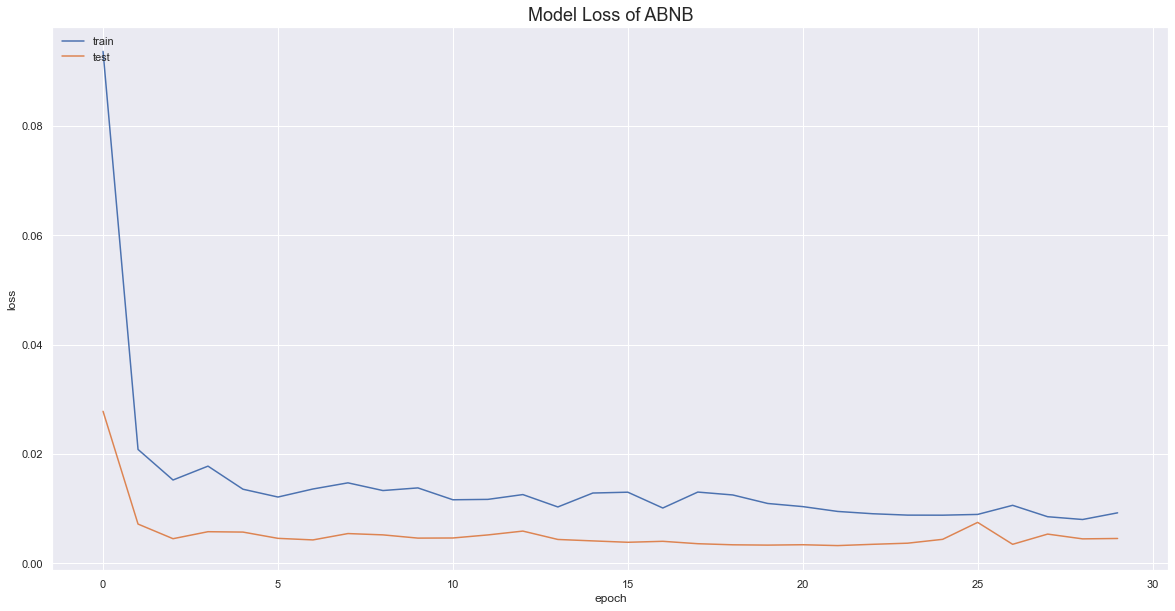

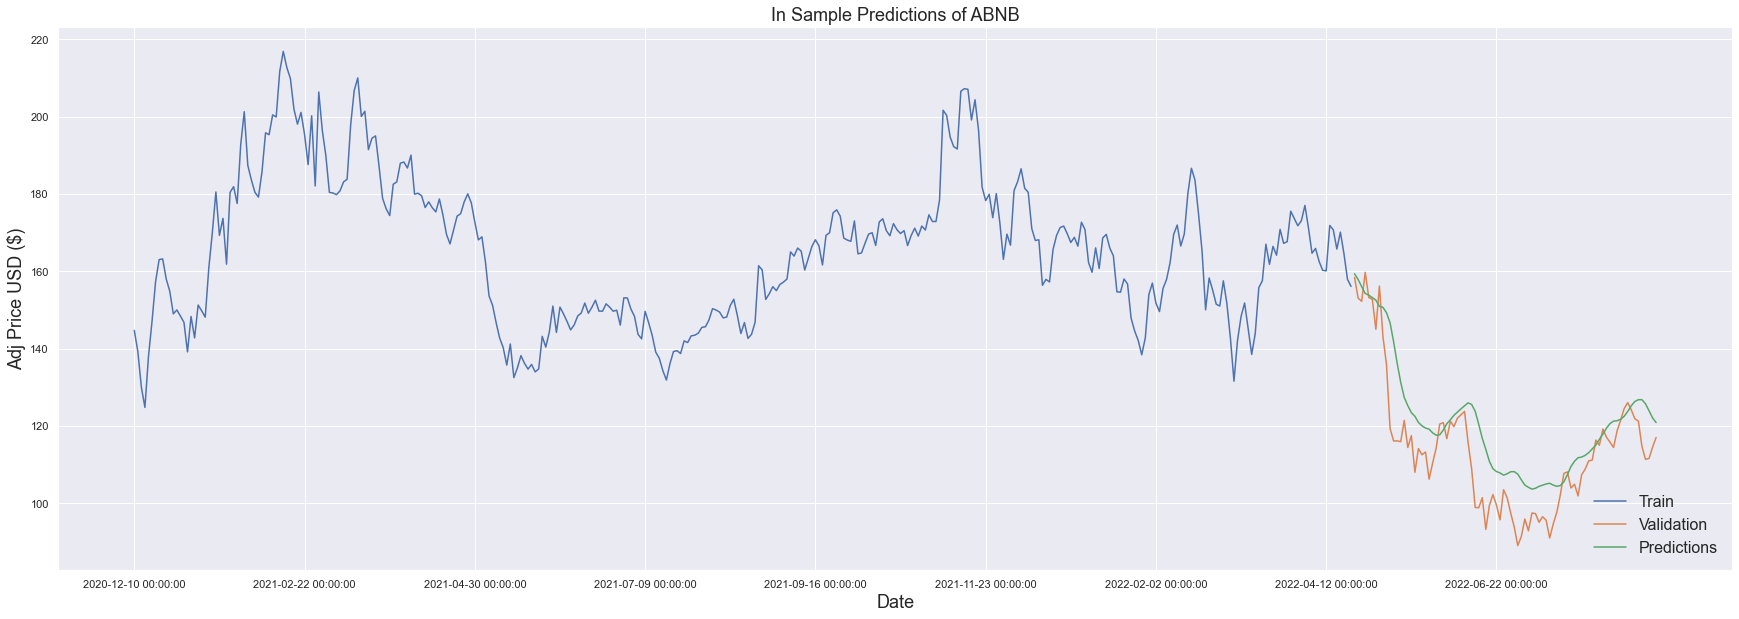

In [20]:
LSTM_Evaluation('ABNB')